# **DSFM Exercise**: Model Evaluation - Cost-Sensitive Learning from Imbalanced Data (SOLUTION)

Creator: [Data Science for Managers - EPFL Program](https://www.dsfm.ch)  
Source:  [https://github.com/dsfm-org/code-bank.git](https://github.com/dsfm-org/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

-------------

## Overview

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. In case of a fraudulent transaction, the credit card company can incur substantial costs. In this exercise, we model the costs associated with prediction errors using a regularized logit model. We will learn that (1) weighting classes and (2) data resampling can help lower real-world costs for prediction errors.


<img src="https://images.unsplash.com/photo-1563013544-824ae1b704d3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=2250&q=80" width="500" height="500" align="center"/>


Image source: https://images.unsplash.com/photo-1563013544-824ae1b704d3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=2250&q=80




## Data

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The data contain only numerical input variables which are the result of a data transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 

Variables are defined as follows: 

| Feature name     | Variable Type | Description 
|------------------|---------------|--------------------------------------------------------
| Time             | Continuous    | Seconds elapsed between each transaction and the first transaction in the dataset
| V1               | Continuous    | Transformed feature 1 (due to confidentiality)
| ...              | ...           | ...
| V28              | Continuous    | Transformed feature 28
| Amount           | Continuous    | Transaction amount
| Class            | Binary        | Target variable (1 = fraud; 0 = no fraud)

Data source: https://www.kaggle.com/mlg-ulb/creditcardfraud



References:

- [Jason Brownlee on MachineLearningMastery.com](https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/)
- [Elkan (2001) - The Foundations of Cost-Sensitive Learning](http://web.cs.iastate.edu/~honavar/elkan.pdf)
- [Thai-Nghe et al. (2010) - Cost-sensitive learning methods for imbalanced data](https://ieeexplore.ieee.org/document/5596486)

## **Part 0**: Setup

### Import packages

In [1]:
# Standard imports
import pandas as pd

# Statistical modeling functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, plot_confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.utils           import resample


### Define constants

In [2]:
# Think of CHF costs for prediction errors (change these costs -> click "Run All" -> see how model performance changes)
# Default = 1000
COST_FN = 1000

# Default = 1
COST_FP = 1

# Column names
COLUMN_NAMES = ["Time", "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", "V14", "V15",
                "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24" ,"V25", "V26", "V27", "V28", "Amount", "Class"]

# Seed for replication
SEED = 42

### Download data

Run the cell below to download the .csv data from our Google Cloud storage bucket.

In [3]:
!wget -N 'https://storage.googleapis.com/dsfm/creditcard/creditcard.csv.zip'
!unzip -o -j creditcard.csv.zip

--2020-09-09 13:54:49--  https://storage.googleapis.com/dsfm/creditcard/creditcard.csv.zip
Resolving storage.googleapis.com... 216.58.215.240, 172.217.168.48, 172.217.168.16
Connecting to storage.googleapis.com|216.58.215.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68787176 (66M) [application/zip]
Saving to: 'creditcard.csv.zip'

creditcard.csv.zip  100%[===================>]  65.60M  12.7MB/s    in 5.6s    

2020-09-09 13:54:55 (11.6 MB/s) - 'creditcard.csv.zip' saved [68787176/68787176]

Archive:  creditcard.csv.zip
  inflating: creditcard.csv          
  inflating: ._creditcard.csv        


## **Part 1**: Load data

First, we load in the credit card data and summarize the data.

**Q 1**: Load the `creditcard.csv` file and set the column names, using the column names defined above. Display the first 5 rows and the shape of the dataframe.

In [4]:
# Load the dataset
df = pd.read_csv('creditcard.csv', names = COLUMN_NAMES)

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Q 2**: Are any missing values in the data? What are the summary statistics for each column? 

In [5]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.165980e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.373150e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.086869e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.490107e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.177556e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406455e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [6]:
# Missing values by variable
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

## **Part 2**: EDA and train/test split

Next, we investigate the class distribution of the target.

**Q 1**: Plot a histogram of the target variable `Class`. 

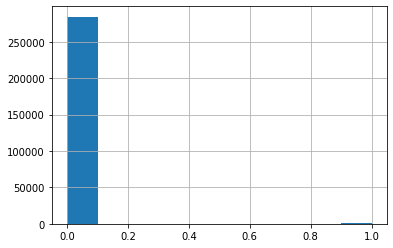

In [7]:
df['Class'].hist()

**Q 2**: What percentage of transactions are fraudulent? 

Hint: Use the `value_counts` function in Pandas on the `Class` variable to count the number of transactions.

In [8]:
count = df['Class'].value_counts()
count

0    284315
1       492
Name: Class, dtype: int64

In [9]:
# Percentage of fraudulent transactions
percentage_fraudulent = count[1] / (count[1] + count[0]) * 100
print('{}% of transactions are fraudulent'.format(round(percentage_fraudulent, 4)))

0.1727% of transactions are fraudulent


**Q 3**: Split the data into training (80%) and testing data (20%). What's the shape of all four data sets?

Hint: Don't forget to stratify by the target variable. Why?

In [10]:
# Divide data into training and testing sets
X = df.drop(columns=['Class'], inplace=False)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = SEED, stratify = y)

print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

(227845, 30) (56962, 30) (227845,) (56962,)


## **Part 3**: Baseline - all predictions errors have the same cost

In this part, we establish the baseline that (naively) assigns uniform costs to each prediction error. We use a regularized l2 logistic regression model throughout this exercise. For the baseline, the model does not know that costs for FP and FN are different.

**Q 1**: Fit the logit model and predict fraud on the test data as a probability between 0 and 1. What does the confusion matrix look like? 

Hint: Use the `plot_confusion_matrix` in the `sklearn` package to plot the confusion matrix.

56962 observations


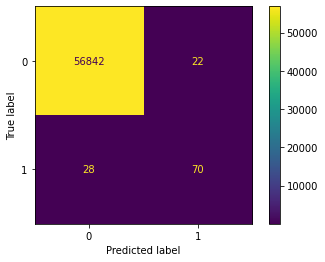

In [11]:
# Binary classification using a logit model
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train, y_train)

# Predict fraud - as a binary outcome and a probability between 0 and 1
y_pred_lr       = lr_clf.predict(X_test)
y_pred_lr_proba = lr_clf.predict_proba(X_test)

# Plot confusion matrix
print('{} observations'.format(len(X_test)))
cm_baseline = plot_confusion_matrix(lr_clf, X_test, y_test, values_format='.5g')
cm_baseline

**Q 2**: Count the total prediction errors, compute the accuracy score, AUC score, and the total prediction costs.

In [12]:
# How many errors did the the model make?
cm_lr = confusion_matrix(y_test, y_pred_lr)
errors_baseline = cm_lr[0][1] + cm_lr[1][0]
cost_baseline = cm_lr[0][1] * COST_FP + cm_lr[1][0] * COST_FN

acc_baseline  = accuracy_score(y_test, y_pred_lr)
auc_baseline  = roc_auc_score(y_test, y_pred_lr_proba[:, 1])
f1_baseline   = f1_score(y_test, y_pred_lr, average='weighted')

print('Num errors =', errors_baseline, '\n')
print('Accuracy   =', "{0:.4f}".format(acc_baseline))
print('AUC score  =', "{0:.4f}".format(auc_baseline))
print('F1 score   =', "{0:.4f}".format(f1_baseline))
print('Total cost =', "CHF {0:.2f}".format(cost_baseline))

Num errors = 50 

Accuracy   = 0.9991
AUC score  = 0.9495
F1 score   = 0.9991
Total cost = CHF 28022.00


**Comment**: We see that the model performs reasonably well judging from AUC and F1 scores. It still makes 28 FN prediction errors, which are particularly expensive. 

## **Part 4**: Class weights - modifying algorithm parameters

One approach to cost-sensitive learning for imbalanced classification is to up-weigh the minority class, which we will implement in this part. 

**Q 1**: Fit the same logit model as in Part 3, but set the `class_weight` parameter in the `LogisticRegression` function to represent different prediction error costs.

Hint: You can re-use the code from Part 3, Question 1. All you have to add is a value for the `class_weight` parameter in the `LogisticRegression` function.

56962 observations


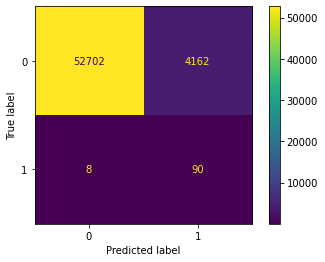

In [13]:
# Binary classification using a logit model
lr_clf = LogisticRegression(max_iter = 1000, class_weight={0:COST_FP, 1: COST_FN})
lr_clf.fit(X_train, y_train)

# Predict fraud - as a binary outcome and a probability between 0 and 1
y_pred_lr       = lr_clf.predict(X_test)
y_pred_lr_proba = lr_clf.predict_proba(X_test)

# Plot confusion matrix
print('{} observations'.format(len(X_test)))
cm_weighted = plot_confusion_matrix(lr_clf, X_test, y_test, values_format='.5g')
cm_weighted

**Q 2**: Count the total prediction errors, compute the accuracy score, AUC score, and the total prediction costs.

Hint: You can re-use the code from Part 3, Question 2.

In [14]:
# How many errors did the model make?
cm_lr = confusion_matrix(y_test, y_pred_lr)
errors_weighted = cm_lr[0][1] + cm_lr[1][0]
cost_weighted = cm_lr[0][1] * COST_FP + cm_lr[1][0] * COST_FN

acc_weighted  = accuracy_score(y_test, y_pred_lr)
auc_weighted  = roc_auc_score(y_test, y_pred_lr_proba[:, 1])
f1_weighted   = f1_score(y_test, y_pred_lr, average='weighted')

print('Num errors =', errors_weighted, '\n')
print('Accuracy   =', "{0:.4f}".format(acc_weighted))
print('AUC score  =', "{0:.4f}".format(auc_weighted))
print('F1 score   =', "{0:.4f}".format(f1_weighted))
print('Total cost =', "CHF {0:.2f}".format(cost_weighted))

Num errors = 4170 

Accuracy   = 0.9268
AUC score  = 0.9693
F1 score   = 0.9604
Total cost = CHF 12162.00


**Comment**: We see that the number of FNs was reduced from 28 to 8, substantially reducing the total prediction costs. However, the number of FP increase by two orders of magnitude (!). Given the FN and FP costs, the benefits of reducing FNs outweigh the higher costs of more FPs.

## **Part 5**: Data resampling - modifying training data

Another approach to tackling the class imbalance problem is to resample data. One can resample by undersampling the majority class (not fraudulent) or oversampling the minority class (fraudulent), as summarized by the image below. Given our pre-defined costs for prediction errors, this is also called "cost-proportionate resampling".

<img src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png" width="700" height="500" align="center"/>

Image source: https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png

**Q 1**: Upsample the minority class using the `resample` function in the `sklearn` package.

Hint: Only use the TRAINING data for resampling, not the full dataset. We want to leave the TESTING data untouched for evaluating performance.

In [15]:
# Re-construct the training data with the target variable
Xy_train = X_train.copy()
Xy_train['Class'] = y_train

# Separate majority and minority classes
df_majority = Xy_train[Xy_train['Class'] == 0]
df_minority = Xy_train[Xy_train['Class'] == 1]

print('{} majority samples in the training data.'.format(len(df_majority)))
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace = True,                # sample with replacement
                                 n_samples = len(df_majority),  # to match majority class
                                 random_state = SEED)           # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled_train = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled_train['Class'].value_counts()

227451 majority samples in the training data.


1    227451
0    227451
Name: Class, dtype: int64

**Q 2**: Re-fit the same logit model as in Part 3, but with the upsampled training data and unchanged testing data. Before doing that, make sure to split the features (X) from the target (y) variable.

In [16]:
# Divide data into features and target variables
X_train_upsampled = df_upsampled_train.drop(columns=['Class'], inplace=False)
y_train_upsampled = df_upsampled_train['Class']

print(X_train_upsampled.shape , X_test.shape , y_train_upsampled.shape , y_test.shape)

(454902, 30) (56962, 30) (454902,) (56962,)


56962 observations


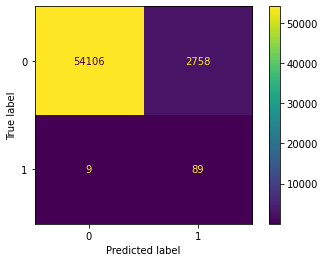

In [17]:
# Binary classification using a logit model
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train_upsampled, y_train_upsampled)

# Predict fraud - as a binary outcome and a probability between 0 and 1
y_pred_lr       = lr_clf.predict(X_test)
y_pred_lr_proba = lr_clf.predict_proba(X_test)

# Plot confusion matrix
print('{} observations'.format(len(X_test)))
cm_resampled = plot_confusion_matrix(lr_clf, X_test, y_test, values_format='.5g')
cm_resampled

**Q 2**: Count the total prediction errors, compute the accuracy score, AUC score, and the total prediction costs. What changed?

Hint: You can re-use the code from Part 3, Question 2.

In [18]:
# How many errors did the model make?
cm_lr = confusion_matrix(y_test, y_pred_lr)
errors_resampled = cm_lr[0][1] + cm_lr[1][0]
cost_resampled = cm_lr[0][1] * COST_FP + cm_lr[1][0] * COST_FN

acc_resampled  = accuracy_score(y_test, y_pred_lr)
auc_resampled  = roc_auc_score(y_test, y_pred_lr_proba[:, 1])
f1_resampled   = f1_score(y_test, y_pred_lr, average='weighted')

print('Num errors =', errors_resampled, '\n')
print('Accuracy   =', "{0:.4f}".format(acc_resampled))
print('AUC score  =', "{0:.4f}".format(auc_resampled))
print('F1 score   =', "{0:.4f}".format(f1_resampled))
print('Total cost =', "CHF {0:.2f}".format(cost_resampled))

Num errors = 2767 

Accuracy   = 0.9514
AUC score  = 0.9675
F1 score   = 0.9735
Total cost = CHF 11758.00


**Comment**: We see that the number of False Negatives slightly increased from 8 to 9, but the number of False Positives also decreased substantially. In sum, the total costs are slightly lower for the data resampling approach than for the class weights approach. 

## **Part 6**: Summary of ROC curves and model performances


### ROC curves

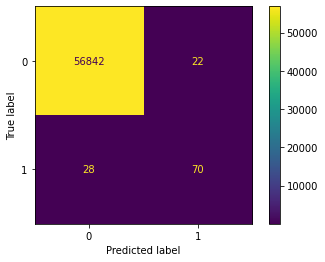

In [19]:
# Baseline
cm_baseline.plot(values_format='.5g')

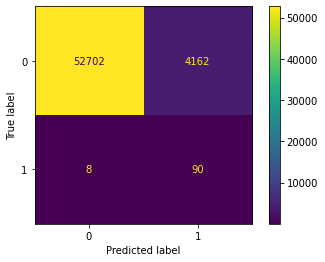

In [20]:
# Class weights
cm_weighted.plot(values_format='.5g')

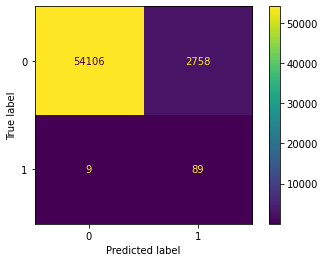

In [21]:
# Resampling
cm_resampled.plot(values_format='.5g')

### Performance, errors, and costs

In [22]:
# Print summary of model performances
width     = 25
width_box = 100
models    = ['Baseline', 'Class weights', 'Resampling']
metrics   = [' Accuracy', ' AUC', ' F1', ' Num errors', ' CHF costs']
accs      = [acc_baseline, acc_weighted, acc_resampled]
aucs      = [auc_baseline, auc_weighted, auc_resampled]
f1s       = [f1_baseline, f1_weighted, f1_resampled]
errors    = [errors_baseline, errors_weighted, errors_resampled]
costs     = [cost_baseline, cost_weighted, cost_resampled]
summary   = [accs, aucs, f1s, errors, costs]

print('Summary table: Predictive performance on TEST data.')
print(str('=' * width * (len(models)+1)))
print(''.ljust(width) + '{}'.format(models[0]).ljust(width) + '{}'.format(models[1]).ljust(width) + '{}'.format(models[2]).ljust(width))
print(str('=' * width * (len(models)+1)))
for i in range(len(metrics)):
    line = metrics[i].ljust(width) + '{}'.format(round(summary[i][0], 4)).ljust(width) + '{}'.format(round(summary[i][1], 4)).ljust(width) + '{}'.format(round(summary[i][2], 4)).ljust(width)
    print(line.center(width_box))
print()

Summary table: Predictive performance on TEST data.
                         Baseline                 Class weights            Resampling               
 Accuracy                0.9991                   0.9268                   0.9514                   
 AUC                     0.9495                   0.9693                   0.9675                   
 F1                      0.9991                   0.9604                   0.9735                   
 Num errors              50                       4170                     2767                     
 CHF costs               28022                    12162                    11758                    

